<a href="https://colab.research.google.com/github/GiPaiva/Sismos-Globais/blob/main/Earthquake_Previsoes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sismos Globais – USGS Earthquake Catalog

Integrantes: **Giovanna Paiva Alves** e **Matheus Sanchez Duda**

O catálogo sísmico global é mantido pelo United States Geological Survey (USGS). Os dados são coletados a partir de redes de sismógrafos distribuídos mundialmente e consolidados automaticamente, passando por processos de verificação por sismólogos antes de serem disponibilizados ao público.

# Conectando ao Dataset

Para conectar ao dataset/API, usamos a biblioteca `requests` para fazer requisições HTTP e obter os dados em formato JSON. Lendo a documentação encontramos o endpoint `https://earthquake.usgs.gov/fdsnws/event/1/`, que é o caminho, como se fosse o email do dataset, para requisar os dados

In [59]:
# É assim que o dado vem
# Os dados estão dentro de 'features' e cada evento tem 'properties'
# {'mag': 5.1, 'place': 'Tonga', 'time': 1673105434004, 'updated': 1678575105040, 'tz': None, 'url': 'https://earthquake.usgs.gov/earthquakes/eventpage/us7000j2tk', 'detail': 'https://earthquake.usgs.gov/fdsnws/event/1/query?eventid=us7000j2tk&format=geojson', 'felt': None, 'cdi': None, 'mmi': None, 'alert': None, 'status': 'reviewed', 'tsunami': 0, 'sig': 400, 'net': 'us', 'code': '7000j2tk', 'ids': ',us7000j2tk,', 'sources': ',us,', 'types': ',origin,phase-data,', 'nst': 61, 'dmin': 2.504, 'rms': 0.76, 'gap': 54, 'magType': 'mww', 'type': 'earthquake', 'title': 'M 5.1 - Tonga'}


## Bibliotecas:

In [60]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

## Ligação com o Dataset

**"starttime": "2025-01-01", <br>
"endtime": "2025-12-30",**
<br><br>
Escolhemos a janela de 2025-01-01 / 2025-12-31 , para então pegar do ano inteiro, "Mas ué, o ano ainda não acabou como você vai pegar o dados do que ainda não chegou?", quando eu faço a requisição ele me traz o que tiver disponivel e não me retorna erro nenhum, e então se eu rodar de novo outro dia, não precisaria mudar a data ele vai me trazer o atualizado.

**"minmagnitude": 5.5,**

A escolha da magnitude foi por conta de segundo pesquisas em sites como G1 e Fundação Oswaldo Cruz:
"
Terremotos a partir de magnitude 5,5 já têm potencial para causar danos destrutivos, especialmente em edifícios mal construídos.
"

Se formos ver a escala Richter:
<table>
<tr>
<th>Magnitude (Escala Richter)</th>
<th>Efeitos Típicos</th>
</tr>
<tr>
<td>Menos de 3,5	</td><td>Geralmente não sentido, apenas registrado por sismógrafos.</td>
</tr>
<tr>
<td>3,5 - 5,4	</td><td>Frequentemente sentido, mas raramente causa danos estruturais.</td>
</tr>
<tr>
<td>5,5 - 6,0	</td><td>Danos menores em edifícios bem projetados; danos significativos em construções precárias.</td>
</tr>
<tr>
<td>6,1 - 6,9	</td><td>Pode ser devastador em áreas habitadas num raio de até 180 km.</td>
</tr>
<tr>
<td>7,0 - 7,9	</td><td>Grande terremoto, causando danos graves e destruição em zonas vastas. </td>
</tr>
<tr>
<td>8,0 ou mais</td>	<td>Pode destruir totalmente comunidades perto do epicentro e causar danos sérios num raio de centenas de quilômetros.</td>
</tr>
</table>

Como felizmente esse tipo de terremotos que chegam até essa magnitude 5.5 é até que baixas nosso dataset não estará sobrecarregado, porem só de precaução por ser um dataset bem grande e com uma taxa de atualização alta, um filtro de limite de 20000 foi colocado.

### Quais serão os dados que vamos coletar?

Não acho que um terremoto vá ter um relógio para saber quando agir, mas assim saberemos quantos por dia podem estar acontecendo ;) <br>
**'data_hora'**: Quando aconteceu? Data e a hora Completa <br>
**'data'**: Apenas a data para podermos fazer métricas <br>
**'magnitude'**: A magnitude do terremoto, para sabermos com  base na escala, o quão destrutivel foi <br>
**'profundidade_km'**: Area sentida <br> <br>
Localizações <br>
**'latitude'**: <br>
**'longitude'**: <br>
**'localizacao'**: <br>
<br>
**'tipo'**: Isso é mais pela causa, por exemplo podemos ter diferentes tipo de atividade sismicas, pode ser: vulcanica, tectônica, colapso, explosão. <br>
**'tsunami'**: Ja esse dado nos retorna um booleano se esse abalo sismico teve como consequencia um tsunami <br>

In [61]:
print("🌍 Iniciando coleta de dados do Dataset do USGS...")
print("=" * 80)

url_base = "https://earthquake.usgs.gov/fdsnws/event/1/query"

# Parâmetros para coletar dados desde de janeiro 2025, pegando o ano todo
parametros = {
    "format": "geojson",
    "starttime": "2025-01-01",
    "endtime": "2025-12-30",
    "minmagnitude": 5.5,
    "limit": 20000
}

🌍 Iniciando coleta de dados do Dataset do USGS...


In [62]:
print("📥 Fazendo requisição ao Dataset...")
resposta = requests.get(url_base, params=parametros)

if resposta.status_code == 200:
    print("✅ Dados obtidos com sucesso!")
    dados_json = resposta.json()

    # Extrair dados dos eventos
    lista_eventos = []

    for evento in dados_json['features']:
        props = evento['properties']
        coords = evento['geometry']['coordinates']

        # Converter timestamp para datetime, para tornar a data e hora legíveis
        timestamp = props['time'] / 1000
        data_hora = datetime.fromtimestamp(timestamp)

        evento_dict = {
            'data_hora': data_hora,
            'data': data_hora.date(),
            'magnitude': props['mag'],
            'profundidade_km': coords[2],
            'latitude': coords[1],
            'longitude': coords[0],
            'localizacao': props['place'],
            'tipo': props['type'],
            'tsunami': props['tsunami']
        }

        lista_eventos.append(evento_dict)

    # Criar DataFrame
    df = pd.DataFrame(lista_eventos)

    print(f"📊 Total de eventos coletados: {len(df)}")
    print("=" * 80)

else:
    print(f"❌ Erro na requisição: {resposta.status_code}")

📥 Fazendo requisição ao Dataset...
✅ Dados obtidos com sucesso!
📊 Total de eventos coletados: 474


In [63]:
df.to_csv('dataset_sismos.csv', index=False)

# 4° parte - Redis

In [64]:
!pip install redis redisbloom statsmodels -q

import redis
from redisbloom.client import Client
import warnings

In [65]:
# Agrupar eventos por dia
eventos_por_dia = df.groupby('data').size()
eventos_por_dia_df = eventos_por_dia.reset_index()
eventos_por_dia_df.columns = ['data', 'quantidade']

In [66]:
# Para usar no Colab
!apt-get install redis-server -y > /dev/null 2>&1
!redis-server --daemonize yes

import time
import hashlib
import math
time.sleep(2)

# Conectar ao Redis
r = redis.Redis(host='localhost', port=6379, decode_responses=False)
rb = Client(host='localhost', port=6379)

# Testar conexão
if r.ping():
    print("✅ Redis conectado com sucesso!")
else:
    print("❌ Erro ao conectar no Redis")

✅ Redis conectado com sucesso!


In [67]:
print("=" * 80)
print("🌸 BLOOM FILTER: Detecção de Padrões de Magnitude")
print("=" * 80)

# Implementar Bloom Filter com Python + Redis
class BloomFilter:
    def __init__(self, redis_client, key, size=10000, num_hashes=7):
        self.redis = redis_client
        self.key = key
        self.size = size
        self.num_hashes = num_hashes

    def _get_hash_values(self, item):
        hashes = []
        for i in range(self.num_hashes):
            # Combinar item com seed diferente para cada hash
            h = hashlib.md5(f"{item}:{i}".encode()).hexdigest()
            # Converter para número e pegar posição no bitmap
            hash_value = int(h, 16) % self.size
            hashes.append(hash_value)
        return hashes

    def add(self, item):
        for pos in self._get_hash_values(item):
            self.redis.setbit(self.key, pos, 1)

    def contains(self, item):
        for pos in self._get_hash_values(item):
            if not self.redis.getbit(self.key, pos):
                return False  # Definitivamente NÃO está
        return True  # PROVAVELMENTE está (pode ser falso positivo)

    def clear(self):
        self.redis.delete(self.key)

# Criar Bloom Filter
bloom_key = 'sismos:magnitude_patterns'
bloom = BloomFilter(r, bloom_key, size=10000, num_hashes=7)
bloom.clear()  # Limpar se já existir

print("✅ Bloom Filter criado!")

# Categorizar magnitudes em faixas
def categorizar_magnitude(mag):
    if mag <= 5.5:
        return "moderado"
    elif mag > 5.5 and mag <= 6.9:
        return "forte"
    elif mag > 6.9 and mag <= 7.9:
        return "muito_forte"
    elif mag > 8.0:
        return "extremo"

padroes_adicionados = set()
for _, row in df.iterrows():
    categoria = categorizar_magnitude(row['magnitude'])
    mes = row['data_hora'].month
    padrao = f"{categoria}:{mes}"
    #print(f"Padrao: {padrao}")

    bloom.add(padrao)
    padroes_adicionados.add(padrao)

# Testar consultas
print("\n🔍 TESTANDO CONSULTAS:")
print("-" * 80)

# mag e numero do mês
testes = [
    ("forte:1", "Magnitude forte em Janeiro"),
    ("extremo:7", "Magnitude extrema em Julho"),
    ("extremo:6", "Magnitude moderada em Junho"),
    ("muito_forte:3", "Magnitude muito forte em Março")
]

resultados = []
for padrao, descricao in testes:
    existe_bloom = bloom.contains(padrao)
    existe_real = padrao in padroes_adicionados

    # Verificar se é falso positivo
    if existe_bloom and not existe_real:
        status = "⚠️ FALSO POSITIVO"
    elif existe_bloom:
        status = "✅ SIM"
    else:
        status = "❌ NÃO"

    print(f"{status} | {descricao}")
    print(f"      Padrão: '{padrao}' | Real: {existe_real}")
    print()

    resultados.append({
        'padrao': padrao,
        'bloom': existe_bloom,
        'real': existe_real,
        'correto': existe_bloom == existe_real
    })

# Estatísticas
acertos = sum(1 for r in resultados if r['correto'])
print("=" * 80)
print("📊 ESTATÍSTICAS DO BLOOM FILTER:")
print(f"   • Padrões únicos armazenados: {len(padroes_adicionados)}")
print(f"   • Consultas testadas: {len(resultados)}")
print(f"   • Acertos: {acertos}/{len(resultados)} ({acertos/len(resultados)*100:.0f}%)")
print(f"   • Memória usada: ~{r.memory_usage(bloom_key) / 1024:.2f} KB")
print("=" * 80)

🌸 BLOOM FILTER: Detecção de Padrões de Magnitude
✅ Bloom Filter criado!

🔍 TESTANDO CONSULTAS:
--------------------------------------------------------------------------------
✅ SIM | Magnitude forte em Janeiro
      Padrão: 'forte:1' | Real: True

✅ SIM | Magnitude extrema em Julho
      Padrão: 'extremo:7' | Real: True

❌ NÃO | Magnitude moderada em Junho
      Padrão: 'extremo:6' | Real: False

✅ SIM | Magnitude muito forte em Março
      Padrão: 'muito_forte:3' | Real: True

📊 ESTATÍSTICAS DO BLOOM FILTER:
   • Padrões únicos armazenados: 31
   • Consultas testadas: 4
   • Acertos: 4/4 (100%)
   • Memória usada: ~2.57 KB


🎲 HYPERLOGLOG: Estimativa de Localizações Únicas

📥 Criando HyperLogLogs por mês...

📊 LOCALIZAÇÕES ÚNICAS POR MÊS:
--------------------------------------------------------------------------------
Janeiro      | Estimado:  29 | Real:  29 | Erro:  0.00%
Fevereiro    | Estimado:  24 | Real:  24 | Erro:  0.00%
Março        | Estimado:  26 | Real:  26 | Erro:  0.00%
Abril        | Estimado:  36 | Real:  36 | Erro:  0.00%
Maio         | Estimado:  38 | Real:  38 | Erro:  0.00%
Junho        | Estimado:  25 | Real:  25 | Erro:  0.00%
Julho        | Estimado:  90 | Real:  91 | Erro:  1.10%
Agosto       | Estimado:  50 | Real:  50 | Erro:  0.00%
Setembro     | Estimado:  37 | Real:  37 | Erro:  0.00%
Outubro      | Estimado:  50 | Real:  50 | Erro:  0.00%
Novembro     | Estimado:  35 | Real:  36 | Erro:  2.78%
Dezembro     | Estimado:   0 | Real:   0 | Erro:  0.00%


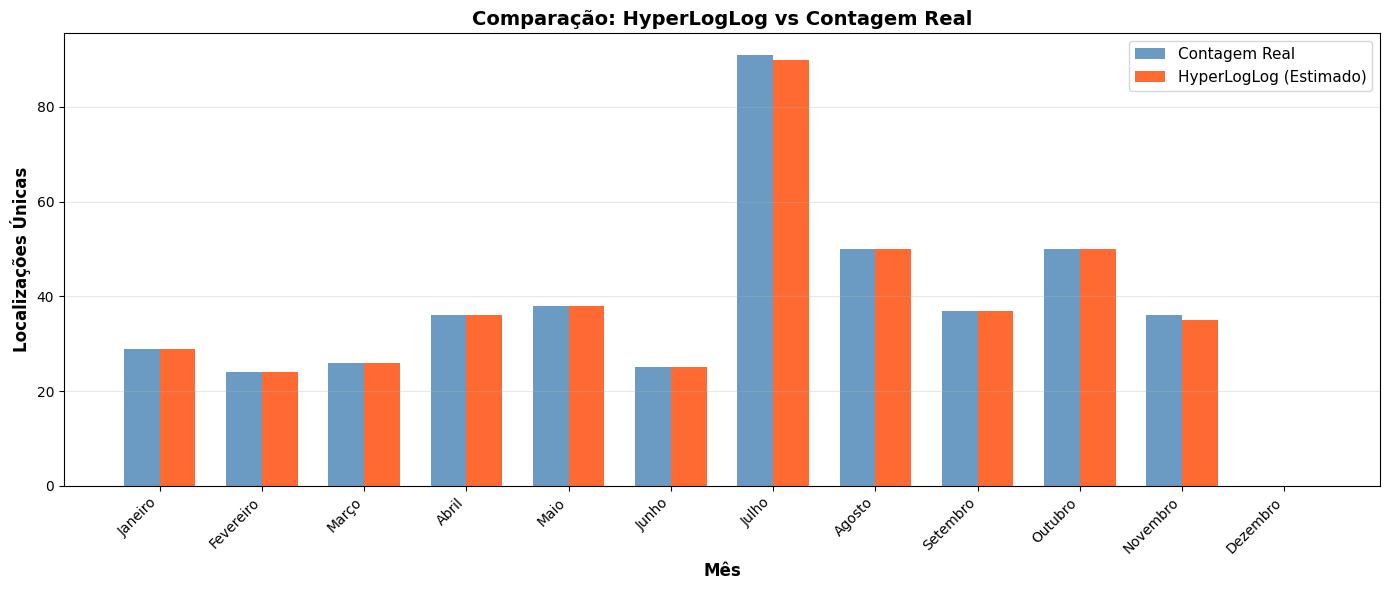


📊 ESTATÍSTICAS GLOBAIS:
   • Total de localizações únicas (Real): 400
   • Total estimado pelo HyperLogLog: 397
   • Erro absoluto: 3
   • Erro percentual: 0.75%
   • Memória usada: ~12 KB por HyperLogLog


In [68]:
print("=" * 80)
print("🎲 HYPERLOGLOG: Estimativa de Localizações Únicas")
print("=" * 80)

# Criar HyperLogLog para cada mês
print("\n📥 Criando HyperLogLogs por mês...")

meses_nomes = {
    1: "Janeiro", 2: "Fevereiro", 3: "Março", 4: "Abril",
    5: "Maio", 6: "Junho", 7: "Julho", 8: "Agosto",
    9: "Setembro", 10: "Outubro", 11: "Novembro", 12: "Dezembro"
}

# Adicionar localizações ao HyperLogLog
for _, row in df.iterrows():
    mes = row['data_hora'].month
    localizacao = row['localizacao']
    key = f'sismos:hll:mes:{mes}'
    r.pfadd(key, localizacao)

# Analisar resultados
print("\n📊 LOCALIZAÇÕES ÚNICAS POR MÊS:")
print("-" * 80)

resultados_hll = []
for mes in sorted(meses_nomes.keys()):
    key = f'sismos:hll:mes:{mes}'
    count_estimado = r.pfcount(key)

    # Contar manualmente para comparar
    dados_mes = df[df['data_hora'].dt.month == mes]
    count_real = dados_mes['localizacao'].nunique()

    erro = abs(count_estimado - count_real)
    erro_pct = (erro / count_real * 100) if count_real > 0 else 0

    print(f"{meses_nomes[mes]:12} | Estimado: {count_estimado:3} | Real: {count_real:3} | Erro: {erro_pct:5.2f}%")

    resultados_hll.append({
        'mes': mes,
        'nome': meses_nomes[mes],
        'estimado': count_estimado,
        'real': count_real
    })

# Plotar comparação
df_hll = pd.DataFrame(resultados_hll)

plt.figure(figsize=(14, 6))
x = range(len(df_hll))
width = 0.35

plt.bar([i - width/2 for i in x], df_hll['real'], width,
        label='Contagem Real', color='steelblue', alpha=0.8)
plt.bar([i + width/2 for i in x], df_hll['estimado'], width,
        label='HyperLogLog (Estimado)', color='orangered', alpha=0.8)

plt.xlabel('Mês', fontsize=12, fontweight='bold')
plt.ylabel('Localizações Únicas', fontsize=12, fontweight='bold')
plt.title('Comparação: HyperLogLog vs Contagem Real', fontsize=14, fontweight='bold')
plt.xticks(x, df_hll['nome'], rotation=45, ha='right')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('hyperloglog_comparacao.png', dpi=300, bbox_inches='tight')
plt.show()

# Estatísticas globais
total_estimado = r.pfcount(*[f'sismos:hll:mes:{m}' for m in meses_nomes.keys()])
total_real = df['localizacao'].nunique()

print("\n" + "=" * 80)
print("📊 ESTATÍSTICAS GLOBAIS:")
print(f"   • Total de localizações únicas (Real): {total_real}")
print(f"   • Total estimado pelo HyperLogLog: {total_estimado}")
print(f"   • Erro absoluto: {abs(total_estimado - total_real)}")
print(f"   • Erro percentual: {abs(total_estimado - total_real)/total_real*100:.2f}%")
print(f"   • Memória usada: ~12 KB por HyperLogLog")
print("=" * 80)